In [1]:
## DATAPREP
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

datapath = "data/gbsg.csv"

class SurvivalDataset:
    def __init__(self,df:pd.DataFrame, time_col: str, event_col: str, features: list[str] = []):
        self.df = df
        self.time_col = time_col
        self.event_col = event_col
        if not features:
            self.features = [c for c in df.columns if c not in [time_col, event_col]]
        else:
            self.features = features
            
        self.time_df = df.loc[:, time_col]
        self.event_df = df.loc[:, event_col]
        self.features_df = df.loc[:, features]
    
df = pd.read_csv(datapath).drop(columns=['pid'])
dataset = SurvivalDataset(df=df, time_col='rfstime', event_col='status')

In [2]:
from lifelines import (
    WeibullFitter,
    ExponentialFitter,
    LogNormalFitter,
    LogLogisticFitter,
    NelsonAalenFitter,
    PiecewiseExponentialFitter,
    GeneralizedGammaFitter,
    SplineFitter,
    KaplanMeierFitter
)
from lifelines.plotting import qq_plot

In [3]:
knots = np.percentile(dataset.time_df.loc[dataset.event_df.astype(bool)], [0, 50, 100])

models = { 
    'Weibull': WeibullFitter(),
    'Exponential': ExponentialFitter(),
    'LogNormal': LogNormalFitter(),
    'LogLogistic': LogLogisticFitter(),
    'NelsonAalen': NelsonAalenFitter(),
    'PiecewiseExponential': PiecewiseExponentialFitter([40, 60]),
    'GeneralizedGamma': GeneralizedGammaFitter(),
    'Spline': SplineFitter(knots),
    'KaplanMeier': KaplanMeierFitter()
}

models_results = {m:{} for m in models}

for model in models:
    models[model] = models[model].fit(dataset.time_df.values, dataset.event_df.values, label=model)

In [4]:
models_results

{'Weibull': {},
 'Exponential': {},
 'LogNormal': {},
 'LogLogistic': {},
 'NelsonAalen': {},
 'PiecewiseExponential': {},
 'GeneralizedGamma': {},
 'Spline': {},
 'KaplanMeier': {}}

In [5]:
for m in models:
    try:
        models_results[m]['AIC'] = models[m].AIC_
        models_results[m]['BIC'] = models[m].BIC_
        models_results[m]['log_likelihood'] = models[m].log_likelihood_
    except AttributeError:
        print(f"\033[91m{m} does not have AIC/BIC/log_likelihood attributes.\033[0m")

NelsonAalen does not have AIC/BIC/log_likelihood attributes.
KaplanMeier does not have AIC/BIC/log_likelihood attributes.


In [6]:
models_results_df = pd.DataFrame(models_results).T
models_results_df.dropna().sort_values(by='AIC')

,AIC,BIC,log_likelihood
Spline,5233.610036,5247.202669,-2613.805018
GeneralizedGamma,5234.157297,5247.749930,-2614.078649
LogNormal,5241.770007,5250.831763,-2618.885004
LogLogistic,5259.894372,5268.956127,-2627.947186
PiecewiseExponential,5269.083873,5282.676506,-2631.541937
Weibull,5278.552727,5287.614482,-2637.276364
Exponential,5297.600213,5302.131091,-2647.800107


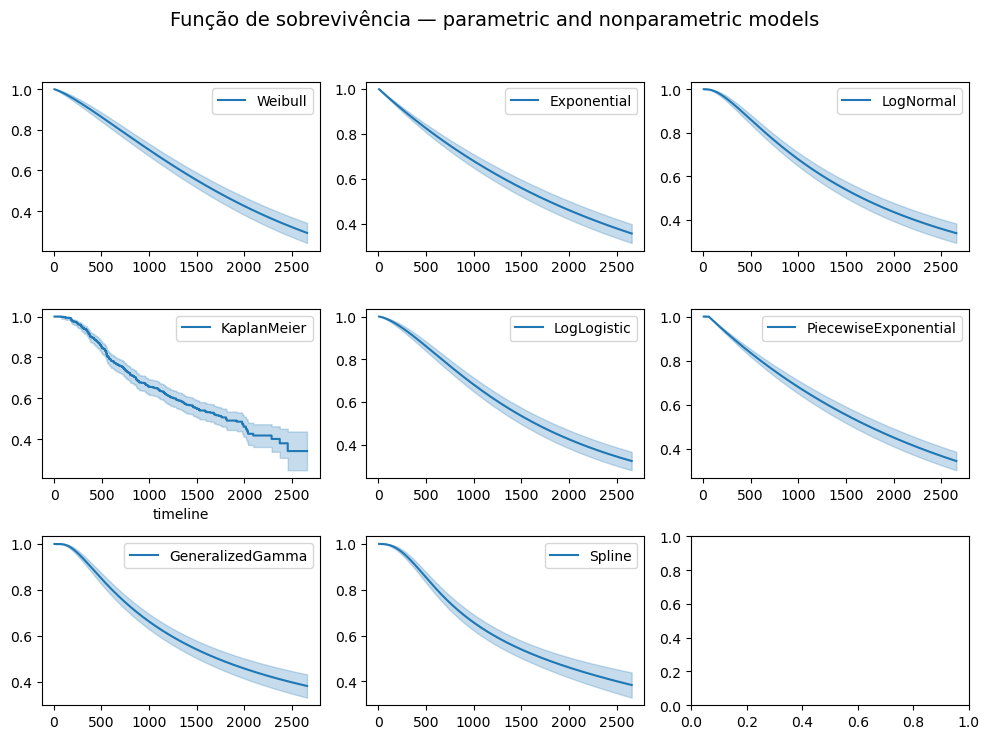

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(10, 7.5))

models['Weibull'].plot_survival_function(ax=axes[0][0])
models['Exponential'].plot_survival_function(ax=axes[0][1])
models['LogNormal'].plot_survival_function(ax=axes[0][2])
models['KaplanMeier'].plot_survival_function(ax=axes[1][0])
models['LogLogistic'].plot_survival_function(ax=axes[1][1])
models['PiecewiseExponential'].plot_survival_function(ax=axes[1][2])
models['GeneralizedGamma'].plot_survival_function(ax=axes[2][0])
models['Spline'].plot_survival_function(ax=axes[2][1])

# Add a centered suptitle and adjust layout so it doesn't overlap the subplots
fig.suptitle('Função de sobrevivência — parametric and nonparametric models', fontsize=14)
# Leave space for the suptitle (top margin) before tightening layout
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

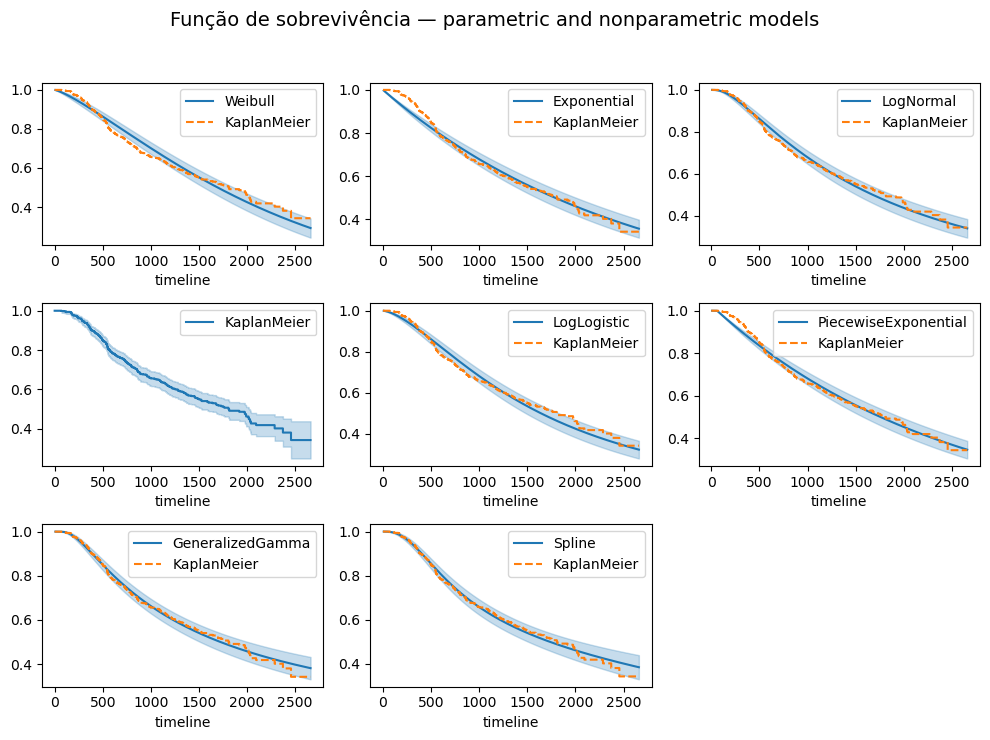

In [13]:
fig, ax_grid = plt.subplots(3, 3, figsize=(10, 7.5))
ax_flat = ax_grid.flatten()

plot_order = [
    'Weibull', 'Exponential', 'LogNormal', 'KaplanMeier',
    'LogLogistic', 'PiecewiseExponential', 'GeneralizedGamma', 'Spline'
]

for i, name in enumerate(plot_order):
    # plot the model
    models[name].plot_survival_function(ax=ax_flat[i])
    # overlay Kaplan-Meier on every subplot except when the subplot is the KM itself
    if name != 'KaplanMeier':
        models['KaplanMeier'].plot_survival_function(
            ax=ax_flat[i],
            ci_show=False,
            label='KaplanMeier',
            linestyle='--'
        )

# hide the unused (9th) subplot
ax_flat[-1].axis('off')

fig.suptitle('Função de sobrevivência — parametric and nonparametric models', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

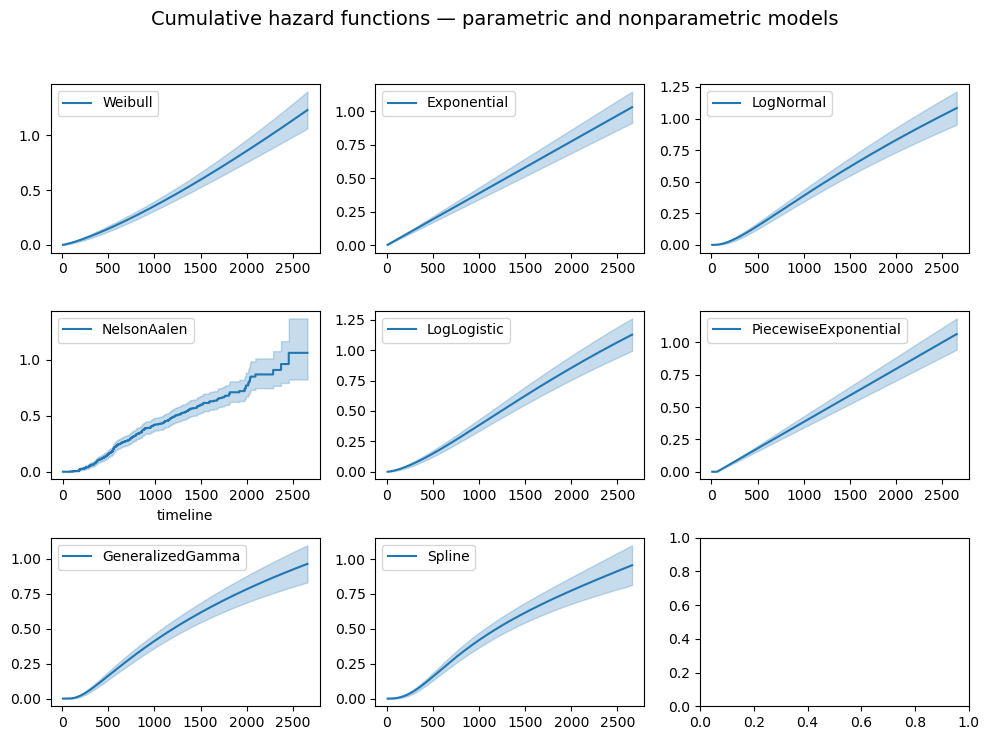

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(10, 7.5))


models['Weibull'].plot_cumulative_hazard(ax=axes[0][0])
models['Exponential'].plot_cumulative_hazard(ax=axes[0][1])
models['LogNormal'].plot_cumulative_hazard(ax=axes[0][2])
models['NelsonAalen'].plot_cumulative_hazard(ax=axes[1][0])
models['LogLogistic'].plot_cumulative_hazard(ax=axes[1][1])
models['PiecewiseExponential'].plot_cumulative_hazard(ax=axes[1][2])
models['GeneralizedGamma'].plot_cumulative_hazard(ax=axes[2][0])
models['Spline'].plot_cumulative_hazard(ax=axes[2][1])

# Add a centered suptitle and adjust layout so it doesn't overlap the subplots
fig.suptitle('Cumulative hazard functions — parametric and nonparametric models', fontsize=14)
# Leave space for the suptitle (top margin) before tightening layout
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

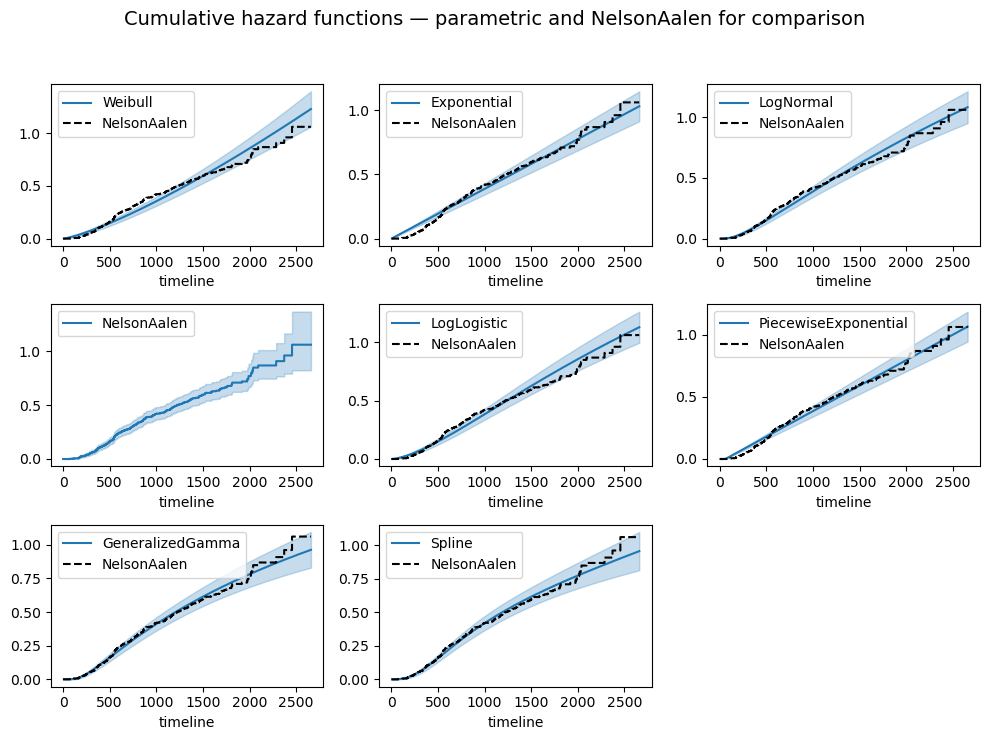

In [14]:
fig_ch, ax_grid_ch = plt.subplots(3, 3, figsize=(10, 7.5))
ax_flat_ch = ax_grid_ch.flatten()

plot_order = [
    'Weibull', 'Exponential', 'LogNormal', 'NelsonAalen',
    'LogLogistic', 'PiecewiseExponential', 'GeneralizedGamma', 'Spline'
]

for i, name in enumerate(plot_order):
    # main model cumulative hazard
    models[name].plot_cumulative_hazard(ax=ax_flat_ch[i])
    # overlay NelsonAalen on every subplot (skip overlaying on itself to avoid duplicate)
    if name != 'NelsonAalen':
        models['NelsonAalen'].plot_cumulative_hazard(
            ax=ax_flat_ch[i],
            ci_show=False,
            label='NelsonAalen',
            linestyle='--',
            color='k'
        )
    ax_flat_ch[i].legend()

# hide the unused (9th) subplot
ax_flat_ch[-1].axis('off')

fig_ch.suptitle('Cumulative hazard functions — parametric and NelsonAalen for comparison', fontsize=14)
fig_ch.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Model Selection using QQPLot


In [11]:
def check_qq_plot_support(models):
    allowed_models = []
    for model_name in models:
        try:
            qq_plot(models[model_name])
            plt.close()  # Close the plot without displaying
            print(f"\033[92mQQ-plot supported for {model_name}\033[0m")  # Green text
            allowed_models.append(model_name)
        except Exception:
            print(f"\033[91mQQ-plot not implemented for {model_name}\033[0m")  # Red text
    return allowed_models

allowed_models = check_qq_plot_support(models)
plt.close()

QQ-plot supported for Weibull
QQ-plot supported for Exponential
QQ-plot supported for LogNormal
QQ-plot supported for LogLogistic
QQ-plot not implemented for NelsonAalen
QQ-plot not implemented for PiecewiseExponential
QQ-plot not implemented for GeneralizedGamma
QQ-plot not implemented for Spline
QQ-plot not implemented for KaplanMeier


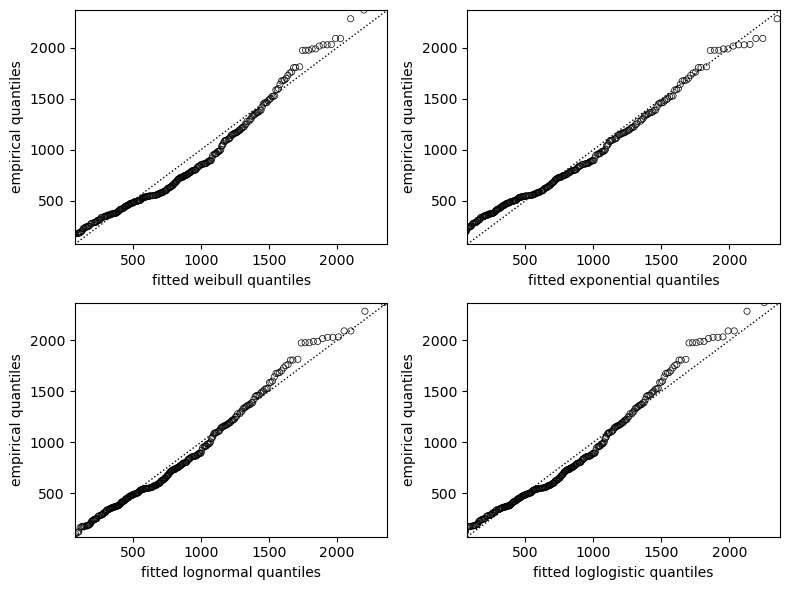

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.reshape(4,)

for i, model in enumerate(allowed_models):
    qq_plot(models[model], ax=axes[i])
    
plt.tight_layout()